In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import idx2numpy
import math
from PIL import Image
import cv2
import scipy.io
import timeit


import tensorflow as tf
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose,LeakyReLU
from tensorflow.keras import losses, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

print("This version of Tensorflow is:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

from bin.STEMnoise import addSTEMnoise

This version of Tensorflow is: 2.9.1
Num GPUs Available:  1
Default GPU Device: /device:GPU:0


In [2]:
##Normalize pixels from 0-1 to match experiment
def normalize(image):
    xmax, xmin = image.max(), image.min()
    norm_image = np.float32((image - xmin)/(xmax - xmin))
    return(norm_image)


# Peak signal-to-noise ratio (PSNR) is the ratio between the maximum possible power of an image and the power 
# of corrupting noise that affects the quality of its representation. 
# To estimate the PSNR of an image, it is necessary to compare that image to an ideal clean image 
# with the maximum possible power.

def calculate_psnr(img1, img2, max_value=1):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))
    
    
def plot_loss(history, x = 'loss', y = 'val_loss'): 
    fig, ax = plt.subplots( figsize=(20,10)) 
    ax.plot(history.history[x]) 
    ax.plot(history.history[y]) 
    plt.title('Model Loss') 
    plt.ylabel(y) 
    plt.xlabel(x) 
    plt.legend(['Train', 'Val'], loc='upper left') 
    ax.grid(color='black') 
    plt.show() 

In [3]:
# Load synthetic dataset 

# dataset_path = Path("./ChromNET Denoiser/data/synthetic_images.hdf5")
hf = h5py.File('./data/simulations/synthetic_images.hdf5', 'r')
synth = np.array(hf["image_data"][:]) #dataset_name is same as hdf5 object name 

In [4]:
# Create 80/20 train/test split

train,test=train_test_split(synth,test_size=0.2,random_state=123)
print('train:',len(train),'test:',len(test))

train: 12702 test: 3176


In [5]:
###Custom Generator for creating train/test batches

#The previous line worked with previous versions of keras and TF < 2.7.0 and plaidml
#class DataGenerator(keras.utils.Sequence):
#class DataGenerator(keras.utils.all_utils.Sequence):
class DataGenerator(Sequence):
#class DataGenerator(Sequential):
    def __init__(self, path, batch_size = 32, n_channels=1, dim=(28,28), shuffle=False):
        self.path = path
        self.n = 0
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.max = self.__len__()

    def __len__(self):
        return int(np.floor(len(self.path) / self.batch_size))
        
    def __add_noise(self,train_dim):
        x_train_noisy = train_dim[:,:,0]
        x_train_noisy = addSTEMnoise(x_train_noisy,0.8,40,0.75,0)
        x_train_noisy = normalize(x_train_noisy)
        noise_factor = 0.15
        x_train_noisy = x_train_noisy + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_noisy.shape)
        x_train_noisy = np.clip(x_train_noisy, 0., 1.)
        x_train_noisy_2 = np.expand_dims(x_train_noisy, axis=2)

        return x_train_noisy_2
    
    
    def __getitem__(self, index):
        #'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.path[k] for k in indexes]

        # Generate data
        X, y = self.__get_data(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        #'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.path))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    

    def __get_data(self,path):
        #'Generates data containing batch_size samples' 
        # X : (n_samples, *dim, n_channels)
        # Initialization

        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        #for i, ID in enumerate(path):
        for i, ID in enumerate(path):
            im = np.array(ID)/255
            #im = np.array(Image.open(ID))/255
            im = cv2.normalize(im, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            im = np.reshape(im, (28,28,1))
            X[i, ] = im
            y[i, ] = self.__add_noise(im)


        return X.astype(np.float32), y.astype(np.float32)

    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result


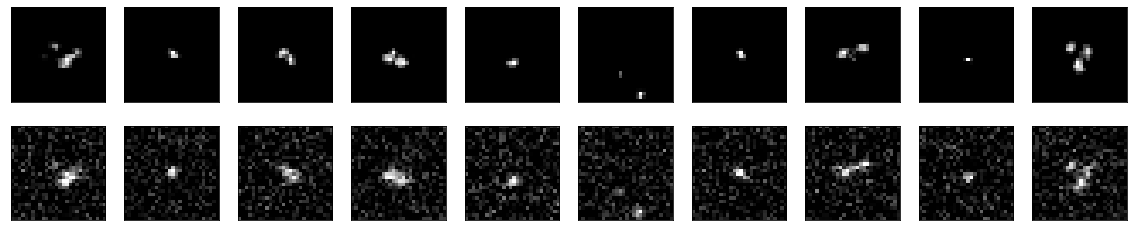

Traning Pixel values: min 0.0 max 1.0
Noisy Train Pixel values: min 0.0 max 1.0


In [6]:
#Create a train and test set using custom generator
training_generator = DataGenerator(train)
testing_generator = DataGenerator(test)
xx, yy = training_generator.__next__()

#Display examples of clean and noisy synthetic images 
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(xx[5-i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(yy[5-i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print('Traning Pixel values:','min',xx.min(),'max',xx.max())
print('Noisy Train Pixel values:','min',yy.min(),'max',yy.max())

In [7]:
input_img = keras.Input(shape=(None, None, 1))

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Model Summary
# print(autoencoder.summary())
# for layer in autoencoder.layers:
#     print(layer.output_shape)
# plot_model(autoencoder,show_shapes=True)

In [8]:
# Train the model (edited for synth data (made smaller))
start = timeit.default_timer()

#Set to False for loading pre-trained model instead 
Retrain = False
epoch = 10

if Retrain == True:
    print('Beeboop... Retraining Network...')
    # Declare the model
    # This callback will stop the training when there is no improvement in
    # the loss for three consecutive epochs.
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history = autoencoder.fit((training_generator),
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(testing_generator), 
                    callbacks=[callback]
                   )
    
    print(len(history.history['loss']), 'epochs run.')
    research_path = Path("D:/Research/chromNET")
    ae_name = './models/new_model_' + str(epoch) + '_epochs' + '.tf'
    ae_path = research_path / ae_name
    autoencoder.save(ae_path)
    plot_loss(history) 
    
else:
    print('Loading Pretrained Model')
    pretrained_model = './models/pretrained_model.tf'
    autoencoder = load_model(pretrained_model)



stop = timeit.default_timer()

print('Time: ', (stop - start)/60, 'minutes')   

Loading Pretrained Model
Time:  0.005956311667493234 minutes


In [9]:
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 256)   2560      
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 128)   295040    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, None, None, 128)  0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 64)    36928     
                                                             

In [10]:
for layer in autoencoder.layers:
    print(layer.output_shape)

[(None, None, None, 1)]
(None, None, None, 256)
(None, None, None, 128)
(None, None, None, 128)
(None, None, None, 64)
(None, None, None, 64)
(None, None, None, 64)
(None, None, None, 128)
(None, None, None, 256)
(None, None, None, 3)


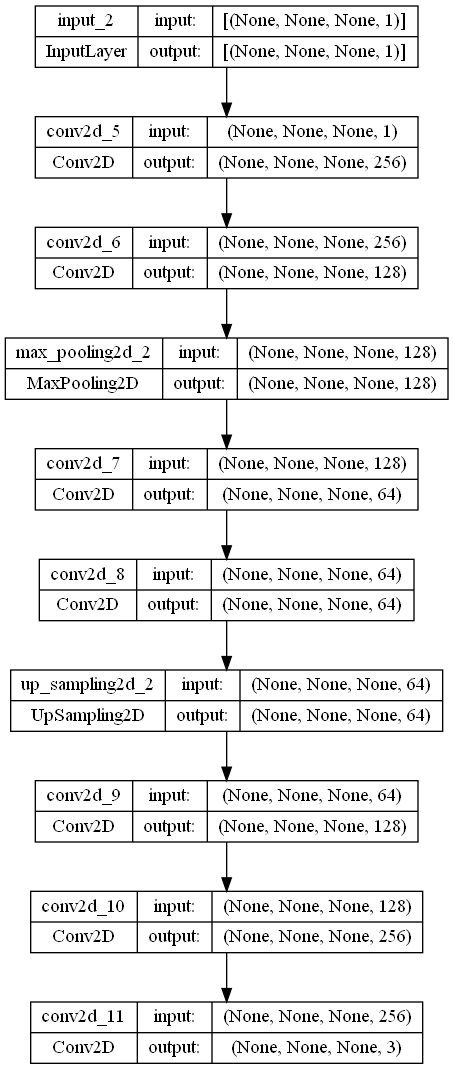

In [11]:
plot_model(autoencoder,show_shapes=True)

396/396 [==============================] - 101s 244ms/step


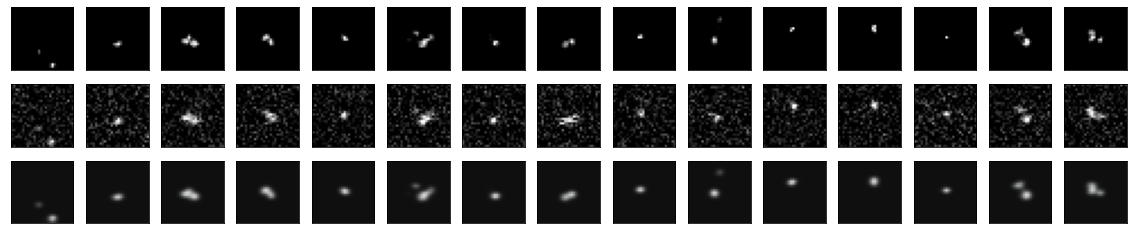

Time:  1.7023386966669931 minutes


In [12]:
start = timeit.default_timer()

#Create a train and test set using custom generator
training_generator = DataGenerator(train)
testing_generator = DataGenerator(test)

#`Model.predict_generator` is deprecated Please use `Model.predict`, which supports generators.
decoded_imgs = autoencoder.predict(training_generator)


n = 15

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original simulation image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(xx[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
   
    # display corrupted image
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(yy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()


stop = timeit.default_timer()

print('Time: ', (stop - start)/60, 'minutes')  

1/1 [==============================] - 0s 26ms/step


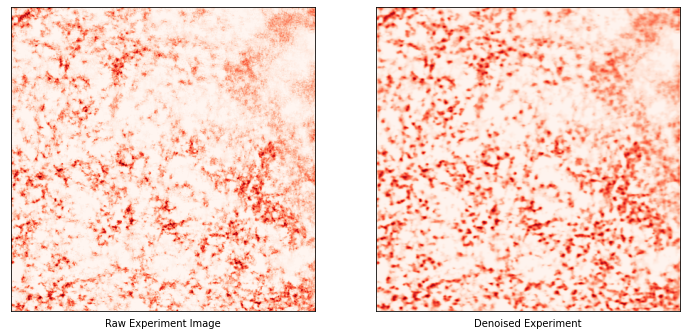

In [13]:
# Load A549 cell image and apply denoising
data = np.load('./data/experiments/a549_cell.npy')
denoised = autoencoder.predict(data)

# Plot raw experimental and denoised image
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,8))

ax1.imshow(data[0,:,:], cmap=plt.cm.Reds)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("Raw Experiment Image")

denoised = autoencoder.predict(data)
ax2.imshow(denoised[0,:,:,0], cmap=plt.cm.Reds)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("Denoised Experiment")

plt.show()